### AutoEncoder

In [117]:
from keras.datasets import mnist
import numpy as np
np.set_printoptions(precision=2)#for decimal precision
import matplotlib.pyplot as plt

#### We will use the mnist dataset for this autoencoder

In [118]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [119]:
X_train.shape

(60000, 28, 28)

#### These images are black and white since this is a 28 by 28

#### Lets scale the pixels

In [120]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

#### We will PCA to compare our different deep learning models

#### First, we will flatten each image into a single row of data. Since our images are 28 by 28, our now dataframe will have rows that are 28*28=784 pixels

In [121]:
X_train_flat = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test_flat = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train_flat.shape)
print(X_test_flat.shape)

(60000, 784)
(10000, 784)


#### PCA works better when our data is scaled, so we will do that

In [122]:
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler().fit(X_train_flat)
X_train_scaled = s.transform(X_train_flat)

In [123]:
from sklearn.decomposition import PCA

#### Lets write a function to get the PCA from the mnist data

In [124]:
def mnist_pca(x_data, n_components):
    pca = PCA(n_components=n_components) #How many componenets we want

    fit_pca = pca.fit(x_data) #fitting the data
    
    print("Variance explained with {0} components:".format(n_components), 
          round(sum(fit_pca.explained_variance_ratio_), 2))

    return fit_pca, fit_pca.transform(x_data) 

In [125]:
pca_full, mnist_data_full = mnist_pca(X_train_scaled, 784)

Variance explained with 784 components: 1.0


In [126]:
pca_full #how many compnents

PCA(n_components=784)

In [127]:
mnist_data_full #the data after PCA is applied

array([[ 4.86e-01, -1.23e+00, -9.60e-02, ..., -1.64e-07,  2.66e-08,
         3.95e-08],
       [ 3.97e+00, -1.16e+00,  2.34e+00, ..., -1.60e-07,  3.78e-07,
         2.74e-07],
       [-2.03e-01,  1.54e+00, -7.39e-01, ..., -2.03e-07,  1.38e-08,
        -2.19e-07],
       ...,
       [-6.98e-01,  6.28e-01, -1.01e+00, ..., -5.40e-08,  1.58e-07,
         7.80e-07],
       [ 5.12e-01, -2.18e-02,  2.02e+00, ...,  9.36e-08, -3.34e-08,
        -1.64e-08],
       [-6.80e-01, -9.69e-02,  2.18e+00, ...,  4.21e-07,  3.29e-08,
         3.19e-07]], dtype=float32)

#### Lets plot this and see what it looks like

Text(0, 0.5, 'Proportion of variance explained')

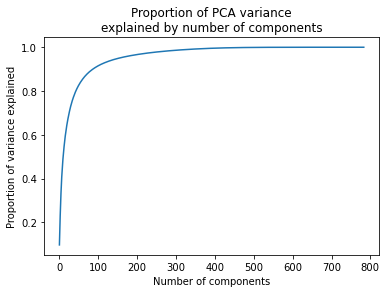

In [128]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_)) #Return the cumulative sum of the elements along a given axis
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained")
#Explained variance ratio is the amount of variance explained by each of the selected components. 

#### We for sure do not need all 784 components to get 100% of the variance explained. Using 150 would give us at least 90%. Lets test this out

In [129]:
pca_2, mnist_data_2 = mnist_pca(X_train_scaled, 150) #model and data

Variance explained with 150 components: 0.95


#### Pretty close! Lets extraxt 2 components and plot them

In [130]:
pca_2, mnist_data_2 = mnist_pca(X_train_scaled, 2)

Variance explained with 2 components: 0.17


In [131]:
mnist_data_2

array([[ 0.49, -1.23],
       [ 3.97, -1.16],
       [-0.2 ,  1.54],
       ...,
       [-0.7 ,  0.63],
       [ 0.51, -0.02],
       [-0.68, -0.1 ]], dtype=float32)

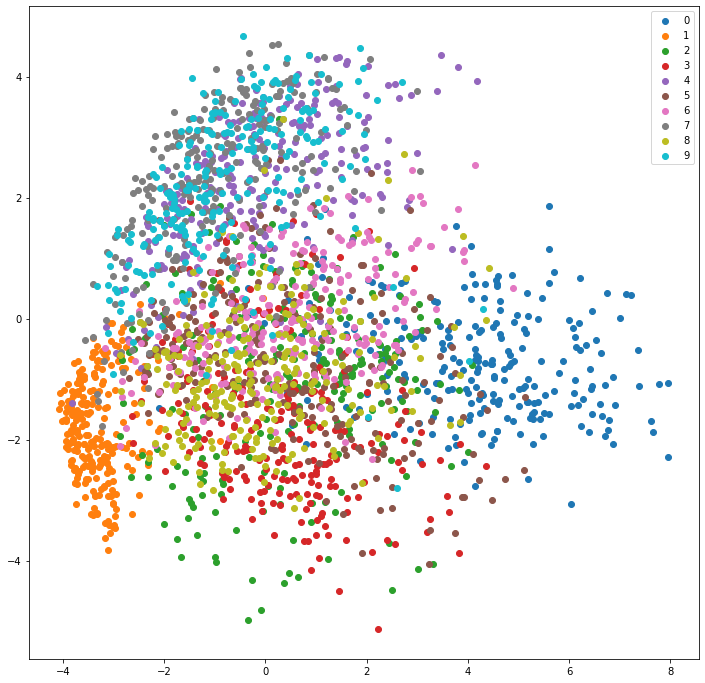

In [132]:
num_images_per_class = 250 #we will only use 250 compnents
fig = plt.figure(figsize=(12,12))
for number in list(range(10)):
    mask = y_train == number 
    x_data = mnist_data_2[mask, 0][:num_images_per_class] #only taking the one that is true from the above statement
    y_data = mnist_data_2[mask, 1][:num_images_per_class]
    plt.scatter(x_data, y_data, label=number, alpha=1)
plt.legend()

#### We can see that the same numbers are grouped together. These features are being captured in PCA. Our NN will help us capture this better

#### What we really care about is: how good is PCA at creating a low dimensional representation of the MNIST data?

In [133]:
pca_64, mnist_data_64 = mnist_pca(X_train_scaled, 64) #Creating another PCA model with only 64 components

Variance explained with 64 components: 0.86


In [134]:
s = MinMaxScaler().fit(X_test_flat) #scalling like we did with the training set
X_test_scaled = s.transform(X_test_flat)

In [135]:
X_test_flat_64 = pca_64.transform(X_test_scaled) #using PCA to transform the data
X_test_reconstructed_64 = pca_64.inverse_transform(X_test_flat_64)

In [136]:
X_test_reconstructed_64.shape #now we have it in 2 dimensions like we want it

(10000, 784)

#### Lets see how well this is

In [137]:
true = X_test_scaled
reconstructed = X_test_reconstructed_64

In [138]:
def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1]) #getting the error

In [139]:
mse_reconstruction(true, reconstructed)

90.58572

#### Average MSE of 90.6, using 64 components, for PCA.

#### Let's now see if we can create an auto encoder to do better than this

In [140]:
from keras.layers import Input, Dense
from keras.models import Model

In [141]:
import keras
from keras import layers

#### Building the model

In [153]:
ENCODING_DIM = 64

# Encoder model
inputs = Input(shape=(784,)) 
encoded = Dense(ENCODING_DIM, activation="sigmoid")(inputs)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
reconstruction = Dense(784, activation="sigmoid")(encoded_inputs)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

#### Lets compile the model

In [154]:
full_model = Model(inputs=inputs, outputs=outputs)

full_model.compile(optimizer='rmsprop',loss='binary_crossentropy')

#### Fitting the model

In [155]:
history = full_model.fit(X_train_flat, X_train_flat, shuffle=True, epochs=1, batch_size=32)

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2062


In [156]:
full_model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                50240     
                                                                 
 decoder (Functional)        (None, 784)               50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [158]:
encoded_images = encoder_model.predict(X_test_flat)
encoded_images.shape

313/313 [==============================] - 0s 793us/step


(10000, 784)

In [147]:
decoded_images = full_model.predict(X_test_flat)
mse_reconstruction(decoded_images, X_test_flat)

313/313 [==============================] - 0s 766us/step


332.72754

#### This is worse! Lets create a more complex autoencoder

In [159]:
ENCODING_DIM = 64
HIDDEN_DIM = 256

# Encoder model
inputs = Input(shape=(784,)) 
encoded = Dense(ENCODING_DIM, activation="relu")(inputs)
encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(encoded)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [160]:
full_model = Model(inputs=inputs, outputs=outputs)

full_model.compile(optimizer='rmsprop',loss='binary_crossentropy')

In [161]:
history = full_model.fit(X_train_flat, X_train_flat, shuffle=True, epochs=2, batch_size=32)

Epoch 1/2
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1189
Epoch 2/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0874


In [162]:
decoded_images = full_model.predict(X_test_flat)
mse_reconstruction(decoded_images, X_test_flat)

313/313 [==============================] - 0s 956us/step


65.561386

#### This is better than our PCA!